In [1]:
import shutil
import tempfile

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as date
import seaborn as sns
from scipy import stats
from scipy.signal import kaiserord, filtfilt, firwin
from sklearn import linear_model
from sklearn.cluster import FeatureAgglomeration
from sklearn.preprocessing import RobustScaler, Normalizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import BaggingRegressor
from sklearn.feature_selection import RFE

sns.set_context('talk')
np.random.seed(1)

In [2]:
data_crime_raw = (pd.read_csv('.\\NYPD_Complaint_Data_Historic.csv',
                             usecols=['CMPLNT_FR_DT', 'LAW_CAT_CD', 'BORO_NM'],
                             dtype={'LAW_CAT_CD':'category', 'BORO_NM':'category'},
                             parse_dates=['CMPLNT_FR_DT'],
                             date_parser=lambda x: pd.to_datetime(x, format='%m/%d/%Y', errors='coerce'))
                  .rename(columns={'CMPLNT_FR_DT': 'date', 'LAW_CAT_CD': 'crime_type', 'BORO_NM': 'borough'}))

In [3]:
data_311_raw = (pd.read_csv('.\\311_Service_Requests_from_2010_to_Present.csv',
                           usecols=['Created Date', 'Complaint Type', 'Borough'],
                           dtype={'Complaint Type':'category', 'Borough':'category',
                                  'Latitude':float, 'Longitude':float},
                           parse_dates=['Created Date'],
                           date_parser=lambda x: pd.to_datetime(x, format='%m/%d/%Y %I:%M:%S %p', errors='coerce'))
                .rename(columns={'Created Date': 'date', 'Complaint Type': '311type', 'Borough': 'borough'}))

In [4]:
data_crime = data_crime_raw[data_crime_raw.date >= pd.to_datetime(dt.date(2010,1,1))].dropna()
data_311 = data_311_raw[data_311_raw.date < pd.to_datetime(dt.date(2016,1,1))].dropna()

data_crime = data_crime[data_crime.crime_type != 'VIOLATION'].drop('crime_type', 1)
data_311 = data_311[data_311.borough != 'Unspecified']
data_311.borough.cat.remove_unused_categories(inplace=True)

In [5]:
boros = data_crime['borough'].cat.categories.tolist()
d_c_boro = {}
d_311_boro = {}
data = {}

for boro in boros:
    d_c_boro[boro] = data_crime[data_crime['borough']==boro].groupby([
        pd.TimeGrouper(key='date', freq='D')]).size()
    d_c_boro[boro].name = 'crime'
    d_311_boro[boro] = data_311[data_311['borough']==boro].groupby([
        pd.TimeGrouper(key='date', freq='D')])['311type'].value_counts().unstack().fillna(0)

In [6]:
data_merged = {}

for boro in boros:
    data_merged[boro] = d_311_boro[boro].join(d_c_boro[boro])

In [7]:
#A Kaiser window is used, kaiserord calculates beta parameter for window and optimal number of taps for filter
#Firwin calculates N taps (with N optimally calculated by kaiserord)
#filtfilt convolutes taps forward, and then backward to avoid data lag

nyq_rate = 0.5
width = 0.1/nyq_rate
ripple_db = 1000.0
N, beta = kaiserord(ripple_db, width)

cutoff_hz = (1/10)/nyq_rate

taps = firwin(N, cutoff_hz, window=('kaiser', beta), pass_zero=True)

data_filt = {}
filt = {}

for boro in boros:
    filt[boro] = data_merged[boro].apply(lambda x: filtfilt(taps, 1.0, x))
    data_filt[boro] = np.array(data_merged[boro] - filt[boro])

In [8]:
data_scaled = {}
scaler = {}

for boro in boros:
    scaler[boro] = RobustScaler()
    data_scaled[boro] = scaler[boro].fit_transform(data_filt[boro])

In [67]:
regr = {}
regr_base = {}
X_train = {}
Y_train = {}
X_test = {}
Y_test = {}
split_ind = {}

for i, boro in enumerate(boros):
    split_ind[boro] = int(len(data_scaled[boro]) * .7)
    # Split the data into training/testing sets
    X_train[boro] = data_scaled[boro][:split_ind[boro], :-1]
    X_test[boro] = data_scaled[boro][split_ind[boro]:, :-1]
    
    Y_train[boro] = data_scaled[boro][:split_ind[boro], -1]
    Y_test[boro] = data_scaled[boro][split_ind[boro]:, -1]

    # Create linear regression object
    regr_base[boro] = linear_model.LinearRegression()
    regr[boro] = RFE(regr_base[boro])

    # Train the model using the training sets
    regr_base[boro].fit(X_train[boro], Y_train[boro])

In [68]:
predY = regr_base['BRONX'].predict(X_test['BRONX'])

In [69]:
test_data = np.append(X_test['BRONX'], np.reshape(Y_test['BRONX'], (Y_test['BRONX'].shape[0], 1)), axis=1)
pred_data = np.append(X_test['BRONX'], np.reshape(predY, (predY.shape[0], 1)), axis=1)

In [70]:
test_data2 = scaler['BRONX'].inverse_transform(test_data)
pred_data2 = scaler['BRONX'].inverse_transform(pred_data)

In [71]:
test_data3 = test_data2 + filt['BRONX'][split_ind['BRONX']:]
pred_data3 = pred_data2 + filt['BRONX'][split_ind['BRONX']:]

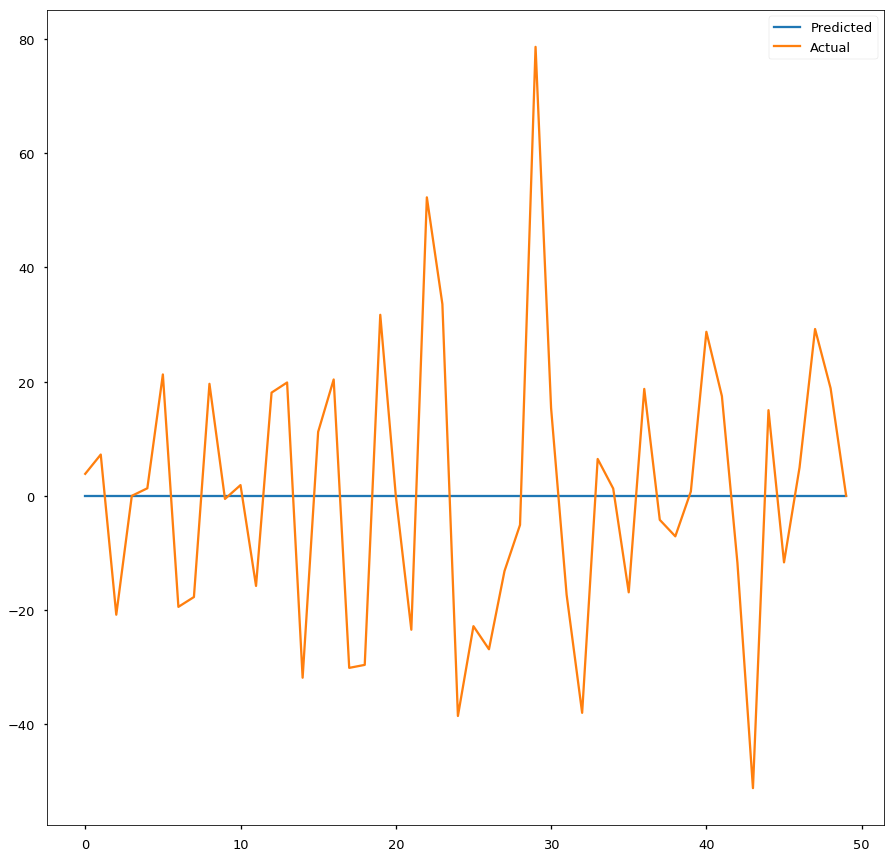

In [72]:
fig, ax = plt.subplots(figsize=(15, 15))
to_plot=50

ax.plot(pred_data2[:, -1][-to_plot:], label='Predicted')
ax.plot(range(len(test_data2[-to_plot:])), test_data2[:, -1][-to_plot:], label='Actual')
ax.legend()
plt.show()

In [32]:
predY = regr['BRONX'].estimator_.predict(regr['BRONX'].transform(X_train['BRONX']))

In [33]:
test_data = np.append(X_train['BRONX'], np.reshape(Y_train['BRONX'], (Y_train['BRONX'].shape[0], 1)), axis=1)
pred_data = np.append(X_train['BRONX'], np.reshape(predY, (predY.shape[0], 1)), axis=1)

In [34]:
test_data2 = scaler['BRONX'].inverse_transform(test_data)
pred_data2 = scaler['BRONX'].inverse_transform(pred_data)

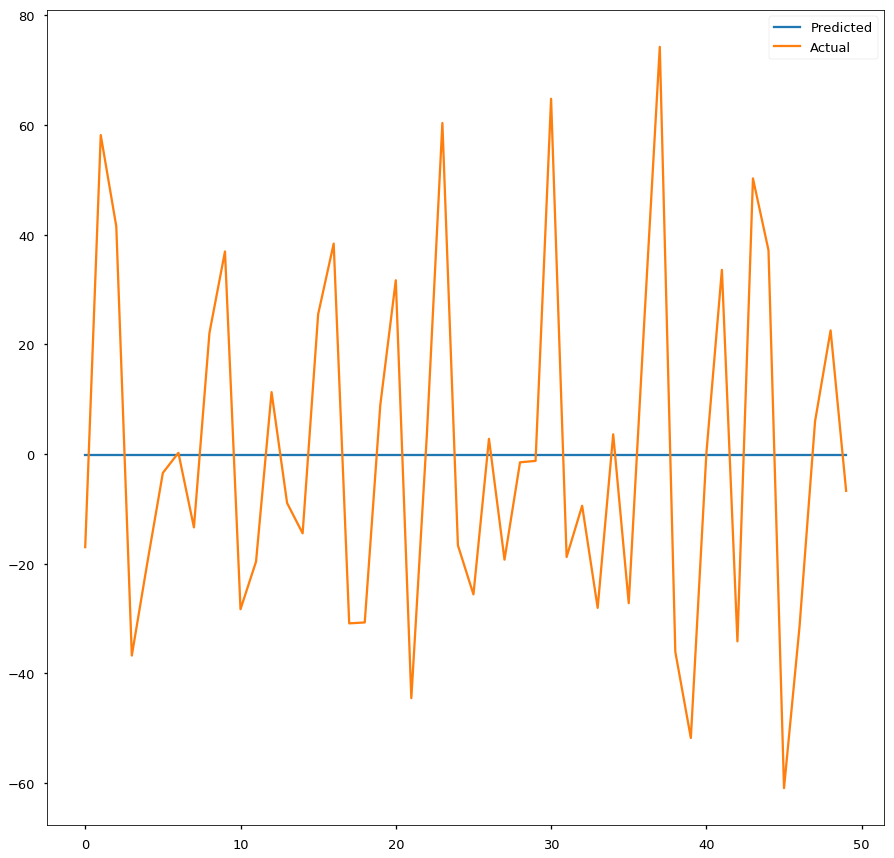

In [35]:
fig, ax = plt.subplots(figsize=(15, 15))
to_plot=50

ax.plot(pred_data2[:, -1][-to_plot:], label='Predicted')
ax.plot(range(len(test_data2[-to_plot:])), test_data2[:, -1][-to_plot:], label='Actual')
ax.legend()
plt.show()